In [1]:
import pandas as pd
import numpy as np
   
tourney_df = pd.read_csv("data/data.csv", index_col=0)
tourney_df.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,dPOM,dPOM_rating,dDOL,dDOL_rating,dCOL,dCOL_rating,dRTH,dRTH_rating,dRPI,dRPI_rating
0,2003,134,1421,92,1411,84,N,1,32,69,...,-5,0.300940,-19,1.168393,-1,0.064190,6,-0.367220,31,-2.022637
1,2003,136,1112,80,1436,51,N,0,31,66,...,-141,20.770848,-154,22.830534,-142,21.967031,-180,24.625314,-142,21.967031
2,2003,136,1113,84,1272,71,N,0,31,59,...,12,-2.353395,27,-4.430384,19,-3.534954,16,-3.078419,6,-1.075410
3,2003,136,1141,79,1166,73,N,0,29,53,...,-23,3.443939,-19,3.636225,-17,3.329047,-33,5.059430,-21,3.468980
4,2003,136,1143,76,1301,74,N,1,27,64,...,-8,1.076629,-24,3.706615,-28,3.975749,-12,1.854306,-20,2.759585


# Choosing Features to Use for Model

Edit featureList below to use any of the features in the data frame above (see above for names of columns).  

In [2]:
systems = ['SAG', 'MOR', 'BOB', 'WOL', 'WLK', 'POM', 'DOL', 'COL', 'RTH', 'RPI']

teamfList = []
#teamfList = systems
teamfList = ['efg', 'to_p', 'orp', 'ftr']
#teamfList.append('wins')
featureList = []
for f in teamfList:
    featureList.append(f+'0')
    featureList.append(f+'1')

for s in systems:
    featureList.append('d'+s+'_rating')
#for f in ['fgm', 'fga', 'fgm3', 'fga3', 'ftm', 'fta', 'or', 'dr', 'ast', 'to', 'stl', 'blk', 'pf']:
#    for mod in ['avg_', 'std_']:
#        featureList.append(mod+f+'0')
#        featureList.append(mod+f+'1')
print("Feature list = {0}".format(featureList))

Feature list = ['efg0', 'efg1', 'to_p0', 'to_p1', 'orp0', 'orp1', 'ftr0', 'ftr1', 'dSAG_rating', 'dMOR_rating', 'dBOB_rating', 'dWOL_rating', 'dWLK_rating', 'dPOM_rating', 'dDOL_rating', 'dCOL_rating', 'dRTH_rating', 'dRPI_rating']


In [3]:
y = tourney_df['team0Win'].values # results
X = tourney_df[featureList].values # features

In [4]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2721)

In [5]:
#from sklearn import preprocessing
#scaler = preprocessing.StandardScaler().fit(X_train)
#print("Means = {0}, Stdevs = {1}".format(scaler.mean_, scaler.scale_))

In [6]:
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

# Train our model!

In [7]:
print(X_train.shape)

(677, 18)


In [10]:
setsize=200.
X_train_sample, X_discard, y_train_sample, y_discard = train_test_split(X_train, y_train, test_size=1.-setsize/X_train.shape[0], random_state=2721)

In [34]:
from sklearn import svm
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

Npts = 10
train_sizes = np.linspace(50,X_train.shape[0], Npts)
#svm_scores = np.zeros(Npts)
rf_scores = np.zeros(Npts)

for i, size in enumerate(train_sizes):
    X_train_sample, X_discard, y_train_sample, y_discard = train_test_split(X_train, y_train, test_size=1.-size/X_train.shape[0], random_state=2721)
    
    ################# SVM On Sample #################### 
    #C_range_s = np.logspace(-3, 3, 7)
    #gamma_range_s = np.logspace(-3, 3, 7)
    #param_grid_s = dict(gamma=gamma_range_s, C=C_range_s)
    #cv_s = StratifiedShuffleSplit(y_train_sample,  n_iter=10 , test_size=0.1, random_state=42)
    #grid_s = GridSearchCV(svm.SVC(probability=True, kernel='rbf'), scoring="log_loss", param_grid=param_grid_s, cv=cv_s, n_jobs=-1)
    #grid_s.fit(X_train_sample, y_train_sample)
    #svm_scores[i] = grid_s.best_score_
    
    ######### Random Forest ###############################
    rfc = RandomForestClassifier(n_jobs=-1,max_features= 'auto' ,n_estimators=50, oob_score = True) 
    param_grid = { 
        'n_estimators': [5, 10,50,100,500],
        'max_features': ['auto','sqrt','log2']
    # Other parameters: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html        
    }
    CV_rfc = GridSearchCV(n_jobs=-1, estimator=rfc, scoring="log_loss", param_grid=param_grid, cv=cv_s)
    CV_rfc.fit(X_train_sample, y_train_sample)
    rf_scores[i] = CV_rfc.best_score_

/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

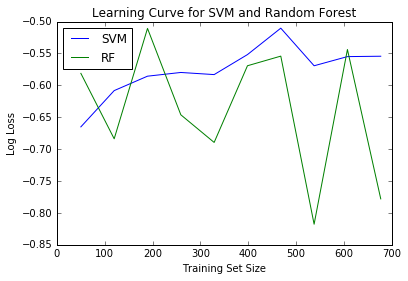

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(train_sizes, svm_scores, label='SVM')
ax.plot(train_sizes, rf_scores, label='RF')
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Log Loss')
ax.set_title('Learning Curve for SVM and Random Forest')
ax.legend(location='best')

In [32]:
from sklearn import svm
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve


################# Training on sample set #################
# setsize = 676 max (origin at 0): Number of training examples to train on (only parameter)
# Note to self : X_train.shape (677, 18)
setsize=50.
X_train_sample, X_discard, y_train_sample, y_discard = train_test_split(X_train, y_train, test_size=1.-setsize/X_train.shape[0], random_state=2721)#y_train_sample=np.ndarray(setsize, dtype=np.int)
#X_train_sample=np.ndarray((setsize,18))
#for ind in range(0, setsize):
#    y_train_sample[ind]=y_train[ind]
#    X_train_sample[ind,]=X_train[ind,]
    
    
    
################# SVM On Sample #################### 
C_range_s = np.logspace(-3, 3, 7)
gamma_range_s = np.logspace(-3, 3, 7)
param_grid_s = dict(gamma=gamma_range_s, C=C_range_s)
cv_s = StratifiedShuffleSplit(y_train_sample,  n_iter=10 , test_size=0.1, random_state=42)
grid_s = GridSearchCV(svm.SVC(probability=True, kernel='rbf'), scoring="log_loss", param_grid=param_grid_s, cv=cv_s, n_jobs=-1)
grid_s.fit(X_train_sample, y_train_sample)



################# SVM (Dan) ####################
#C_range = np.logspace(-3, 3, 7)
#gamma_range = np.logspace(-3, 3, 7)
#param_grid = dict(gamma=gamma_range, C=C_range)
#cv = StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.1, random_state=42)
#grid = GridSearchCV(svm.SVC(probability=True, kernel='rbf'), scoring="log_loss", param_grid=param_grid, cv=cv, n_jobs=-1)
#grid.fit(X_train, y_train)




######### Random Forest ###############################
#rf1=RandomForestClassifier(n_estimators=10)
#rf1=rf1.fit(X_train, y_train)
#scorerf1=rf1.predict(X)
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'auto' ,n_estimators=50, oob_score = True) 
param_grid = { 
    'n_estimators': [5, 10,50,100,500],
    'max_features': ['auto','sqrt','log2']
# Other parameters: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html        
}
CV_rfc = GridSearchCV(n_jobs=-1, estimator=rfc, scoring="log_loss", param_grid=param_grid, cv=cv_s)
CV_rfc.fit(X_train_sample, y_train_sample)


print 

print "Full set: best parameters are %s with a score of %0.4f" % (grid.best_params_, grid.best_score_) 
print "Sample: best parameters are %s with a score of %0.4f" % (grid_s.best_params_, grid_s.best_score_) 
print "Random Forest: ", CV_rfc.best_params_ , CV_rfc.best_score_


/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer


Full set: best parameters are {'C': 0.10000000000000001, 'gamma': 0.001} with a score of -0.5850
Sample: best parameters are {'C': 1.0, 'gamma': 0.001} with a score of -0.6410
Random Forest:  {'max_features': 'log2', 'n_estimators': 100} -0.57796976568


In [ ]:
model = grid.best_estimator_
y_pred = model.predict_proba(X_test) # probability that team0 wins (what Kaggle calls team 1, and wants for submission)
from sklearn import metrics
print("Log loss is {0}".format(metrics.log_loss(y_test, y_pred)))

In [19]:
from sklearn import svm
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
#C_range = np.logspace(0, 3, 4)
#gamma_range = np.logspace(-3,0,4)
classifiers = []
for C in C_range:
    for gamma in gamma_range:
        clf = svm.SVC(probability=True, kernel='rbf',C=C, gamma=gamma)
        clf.fit(X_train, y_train)
        classifiers.append((C, gamma, clf))

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_range), len(gamma_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

ValueError: X.shape[1] = 2 should be equal to 18, the number of features at training time

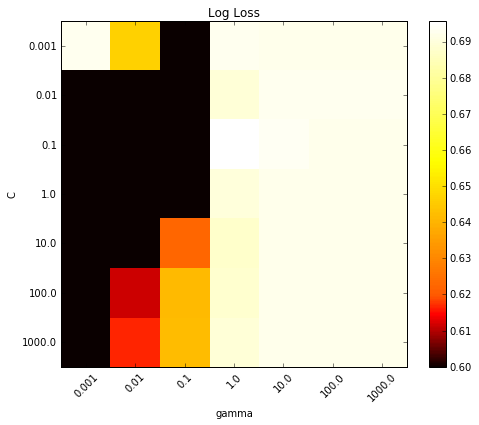

In [23]:
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

    
# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
# We extract just the scores
scores = np.fabs([x[1] for x in grid.grid_scores_])
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.6, midpoint=0.62))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Log Loss')
plt.show()

In [22]:
def write_submission_file(model, featureList, scaler, submission_output_file): # see submission.ipynb for details
    import pandas as pd
    sample_df = pd.read_csv('data/SampleSubmissionWithFeatures.csv', index_col=0)
    Xsample = sample_df[featureList].values
    Xsample = scaler.transform(Xsample)
    sample_df['Pred'] = model.predict_proba(Xsample)[:,1] # predict_proba returns [prob label is 0, prob label is 1], kaggle wants 2nd column
    submission = sample_df[['Id', 'Pred']]
    submission.to_csv(submission_output_file, encoding='ascii', index=False)
submission_output_file = "data/submission.csv"
write_submission_file(model, featureList, scaler, submission_output_file)

In [21]:
submission_df = pd.read_csv(submission_output_file, index_col=0)
submission_df.head()

NameError: name 'submission_output_file' is not defined